# Reproduction: Planning in Dynamic Environments with Conditional Autoregressive Models

**Abhinav Madahar (<abhinav.madahar@rutgers.edu>) &middot; Sungjin Ahn**

Todo:

- [x] Movement about the environment is continuous, but collision and goal checking is quantized to the nearest pixel.
- [x] The agent (controlled by the model) is a $1 \times 1$ object and the goal is $2 \times 2$.
- [x] Both are randomly placed.
- [x] The goal is initialized with a velocity with random direction and fixed speed.
- [x] The agent must reach the goal in a set time without hitting an obstacle.
- [x] The agent can have 1 of 2 fixed speeds, 0.5 pixels/timestep or 1 pixel/timestep.
- [x] At each timestep the agent has the choice of 8 actions. These actions indicate one of 8 equally spaced angles and a constant speed.
- [x] The goal also reflects off world boundaries, like in billards.
- [x] The environment has configurable height and width.
- [x] The environment is divided into obstacle lanes which span the environment horizontally.
- [x] At the beginning of each episode, the lanes are randomly assigned to carry 1 of 5 classes of obstacles and a direction of movement (left to right or right to left). 
- [x] Each obstacle class is parameterized by a color and a distribution which describes average obstacle speed and length. 
- [x] Obstacles maintain a constant speed after entering the environment, pass through the edges of the environment, and are deleted after their entire body exits the observable space.
- [x] The number of obstacles introduced into the environment at each timestep is controlled by a Poisson distribution, configured by the level parameter.
- [x] Encode the environment in a VAE-readable state.
- [x] Make an encoder which reads this environment and compresses it to a continuous 36-vector to mimic the discrete 6x6x1 Z-representation.
- [x] Make dataset of X values (flattened current frame) and y values (flattened next frame).
- [x] Train the model.
- [x] Make goal bounce off walls correctly
- [x] https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
- [ ] Make obstacles come in and out correctly
- [ ] An agent receives a reward of +20 for entering the same pixel-space as the goal and a −20 reward for entering the same pixel-space as an obstacle.

In [52]:
import itertools
import math
import random
from math import sqrt
from collections import namedtuple
from enum import Enum
from math import ceil

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as nn
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import medfilt
from torch import autograd, optim
from torch.autograd import Variable

%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
random.seed(0)

## Making the Environment

We first make the environment.
These are some, but not all, of the parts I need to finish to make the environment.

At first, the agent will be a simple VAE.

I want the `Environment` class to be completely deterministic, assuming that the model is deterministic.
The randomness, like for placing the goal and agent, are separated into other functions.
We also create an enum to keep track of whether the current game is running, has been won, or has been lost.

In [53]:
def flatten(nested):
    values = []
    for element in nested:
        try:
            values = values.concat(flatten(element))
        except:
            values.append(element)
    return values
                    
def sgn(val):
    if val > 0:
        return 1
    elif val == 0:
        return 0
    else:
        return -1

class Vector2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __add__(self, v):
        return Vector2D(self.x + v.x, self.y + v.y)
    
    def __mul__(self, a):
        return Vector2D(a * self.x, a * self.y)
    
    def __repr__(self):
        return '{}({}, {})'.format(type(self).__name__, self.x, self.y)
    
    def __eq__(self, v):
        return self.x == v.x and self.y == v.y

class Position(Vector2D): 
    pass

class Velocity(Vector2D): 
    pass
        
def random_position(height, width):
    """Generates a psuedorandom position where 0 <= x < height and 0 <= y < width. The x and y are integers."""
    return Position(random.randrange(height), random.randrange(width))

def random_velocity(speed):
    theta = random.uniform(-1, 1) * math.pi
    return Velocity(speed * math.cos(theta), speed * math.sin(theta))

class GameState(Enum):
    ONGOING = 0
    WON = 1
    COLLIDED = 2
    TIMEOUT = 3
    
class Direction(Enum):
    LEFT = 0
    RIGHT = 1
    
ObstacleClass = namedtuple('ObstacleClass', ['length', 'speed'])
Obstacle = namedtuple('Obstacle', ['obstacle_class', 'position'])

def obstacle_from_class_id(id):
    """The `id` argument is the class ID in [0, 1, 2, 3, 4]."""
    obstacle_classes = [
        ObstacleClass(3, 1),
        ObstacleClass(3, 2),
        ObstacleClass(6, 1),
        ObstacleClass(6, 2),
        ObstacleClass(1.5, 0.5),
    ]
    return obstacle_classes[id]

def random_obstacle_lanes(n_lanes):
    return [obstacle_from_class_id(random.randrange(5)) for _ in range(n_lanes)]

We can now make the `Environment` class.

In [61]:
class Environment:
    def __init__(self, height, width, agent_pos, goal_pos, agent_speed, goal_vel, max_time, level):
        """
            Initialize the environment.
            
            Args:
                height: int, the height of the environment.
                width: int, the width of the environment.
                agent_pos: Position, the initial position of the agent.
                goal_pos: Position, the initial position of the goal; the goal is 2x2, so the goal_pos is its bottom-left corner.
                agent_speed: float, the speed (not velocity) of the agent. The model controls the direction.
                goal_vel: Velocity, the velocity of the goal at the start of the experiment. This can change if it hits a wall.
                max_time: int, the maximum number of timesteps which can elapse before an automatic loss.
        """
        
        self.height = height
        self.width = width
        
        assert 0 <= agent_pos.x <= width
        assert 0 <= agent_pos.y <= height
        assert 0 <= goal_pos.x <= width - 1
        assert 0 <= goal_pos.y <= height - 1  # ditto
        self.agent_pos = agent_pos
        self.goal_pos = goal_pos

        self.agent_speed = agent_speed
        self.goal_vel = goal_vel
        
        self.max_time = max_time
        self.time = 0
        
        # randomly assign obstacle lanes for each lane.
        # note that a single lane can have multiple obstacles, so we have a list of obstacles in each lane
        n_obstacle_lanes = self.height
        self.n_obstacle_lanes = n_obstacle_lanes
        self.obstacle_classes = random_obstacle_lanes(n_obstacle_lanes)
        self.obstacle_directions = [Direction(random.randrange(2)) for _ in range(n_obstacle_lanes)]
        self.obstacle_lanes = [[] for _ in range(n_obstacle_lanes)]
        
        self.level = level
        self.add_obstacles()
    
    def __repr__(self):
        return 'Environment(height={}, width={}, agent_pos={}, goal_pos={}, agent_speed={}, goal_vel={})'.format(
            self.height, self.width, self.agent_pos, self.goal_pos, self.agent_speed, self.goal_vel)
    
    def __str__(self):
        """An ASCII diagram of the environment."""

        board = '|' + '-' * self.width + '|\n'
        for row in range(self.height):
            board += '|'
            for col in range(self.width):
                if Position(row, col) == self.rounded(self.agent_pos):
                    board += 'a'
                elif Position(row, col) in self.hitbox(self.goal_pos, (2, 2)):
                    board += 'g'
                else:
                    board += ' '
            board += '|\n'
        board += '|' + '-' * self.width + '|'
        
        return board
    
    def move(self):
        """Makes all the objects move in a single timestep and returns the game state."""
        
        def move_object(obj, vel):
            # instead of making a good solution, I made an easy one.
            # we move the object by velocity * dt where dt is a small scalar.
            # if we go out of bounds, then we flip the coordinate(s) which are out of bounds
            dt = 0.01
            for _ in range(int(1 / dt)):
                obj += vel * dt
                
                if obj.x < 0:
                    vel.x = abs(vel.x) * 1  # make sure to go right
                elif obj.x > self.width:
                    vel.x = abs(vel.x) * -1  # make sure to go left
                    
                if obj.y < 0:
                    vel.y = abs(vel.y) * 1  # make sure to go up
                elif obj.y > self.height:
                    vel.y = abs(vel.y) * -1  # make sure to go down

            
            return obj
        
        # we move the agent and goal
        self.agent_pos = move_object(self.agent_pos, self.model_decision())
        self.goal_pos = move_object(self.goal_pos, self.goal_vel)

        # we move the obstacles
        for lane, direction in zip(self.obstacle_lanes, self.obstacle_directions):
            for j, obstacle in enumerate(lane):
                speed     = obstacle.obstacle_class.speed
                direction = 1 if direction == Direction.RIGHT else -1
                obstacle.position.y += speed * direction

        self.remove_out_of_bounds_obstacles()
        self.add_obstacles()
        
        self.time += 1
        
        if self.rounded(self.agent_pos) in self.hitbox(self.goal_pos, [2, 2]):
            return GameState.WON
        
        if self.time >= self.max_time:
            return GameState.TIMEOUT
        
        return GameState.ONGOING

    def hitbox(self, position, shape: [int, int]):
        """
        Returns an array of all the positions which are in this element's hitbox.
        Note that shape = [length in x, height in y].
        """
        
        position = self.rounded(position)
        hitboxes = []
        for offset_y in range(ceil(shape[0])):
            for offset_x in range(ceil(shape[1])):
                hitboxes.append(Position(position.x + offset_x, position.y + offset_y))
        return hitboxes

    def rounded(self, position):
        return Position(round(position.x), round(position.y))
    
    def model_decision(self):
        """Get the model's decision on where to move given the current environment using integers 0 through 7."""
        # until I replicate the model, it will always select action 0
        decision = 0
        decisions = [
            Velocity(-1/sqrt(2), 1/sqrt(2)),  Velocity(0, 1),  Velocity(-1/sqrt(2), -1/sqrt(2)),
            Velocity(-1, 0),                                   Velocity(0, 1),
            Velocity(-1/sqrt(2), -1/sqrt(2)), Velocity(0, -1), Velocity(-1/sqrt(2), -1/sqrt(2)),
        ]
        return decisions[decision] * self.agent_speed
    
    def add_obstacles(self):
        """Add obstacles based on a Poisson distribution."""
        
        # decide into which lanes to add obstacles
        number_obstacles_to_introduce = np.random.poisson(lam=self.level)
        obstacle_lanes = list(range(self.n_obstacle_lanes))
        random.shuffle(obstacle_lanes)
        lanes_in_which_we_add_obstacles = obstacle_lanes[:number_obstacles_to_introduce]
        
        for lane in lanes_in_which_we_add_obstacles:
            end = 0 if self.obstacle_directions[lane] == Direction.RIGHT else self.width
            obstacle = Obstacle(self.obstacle_classes[lane], Position(lane, end))
            self.obstacle_lanes[lane].append(obstacle)
        
    def remove_out_of_bounds_obstacles(self):
        for lane, direction in zip(self.obstacle_lanes, self.obstacle_directions):
            for j, obstacle in enumerate(lane):
                left_moving_and_out_of_bounds = direction == Direction.LEFT and obstacle.position.x + obstacle.obstacle_class.length < 0
                right_moving_and_out_of_bounds = direction == Direction.RIGHT and obstacle.position.x + obstacle.obstacle_class.length > self.width
                
                if left_moving_and_out_of_bounds or right_moving_and_out_of_bounds:
                    lane.pop(j)

    def model_readable_representation(self):
        """Represents the environment using a torch tensor. A point is 0 if empty, 1 if an obstacle is there, and 2 for goal."""
        
        # we have to increment because (self.width, self.height) is a valid point on the board
        rep = np.zeros([self.width+1, self.height+1], dtype=np.float64)
        
        obstacles = []
        for lane in self.obstacle_lanes:
            for obstacle in lane:
                obstacles.append(obstacle)
        obstacle_points = []
        for obstacle in obstacles:
            for point in environment.hitbox(obstacle.position, [obstacle.obstacle_class.length, 1]):
                obstacle_points.append(point)
        
        for position in obstacle_points:
            # obstacles can sometimes go beyond the bounds along the x-axis, 
            # which is valid but makes it impossible to put them on the representation.
            if 0 <= position.x <= self.width and 0 <= position.y <= self.height:
                rep[position.x][position.y] = 0.5

        goal_hitpoints = self.hitbox(self.goal_pos, [2, 1])
        for position in goal_hitpoints:
            if 0 <= position.x < self.width and 0 <= position.y <= self.height:
                rep[position.x][position.y] = 1
        
        rep = torch.from_numpy(rep)
        
        return rep

We can make an environment and see what it looks like when it's run.

In [62]:
height = 45
width = 45
max_time = 407
goal_speed = 1
agent_pos = random_position(height, width)
goal_pos = random_position(height-1, width-1)
agent_speed = 1
goal_vel = random_velocity(goal_speed)
level = 1

In [63]:
%%capture

environment = Environment(height, width, agent_pos, goal_pos, agent_speed, goal_vel, max_time, level)

fig = plt.figure()
ax = plt.axes(xlim=(0, 45), ylim=(0, 45))
a = np.random.random((45, 45))
cmap = LinearSegmentedColormap.from_list('mycmap', ['purple', 'cyan', 'yellow'])
im = plt.imshow(a, interpolation='none', cmap=cmap)

def animate(i):
    frame = environment.model_readable_representation()
    a = im.get_array()
    a = frame
    im.set_array(a)
    environment.move()

    return [im]
    
animation = matplotlib.animation.FuncAnimation(fig, animate, frames=100)

In [ ]:
animation

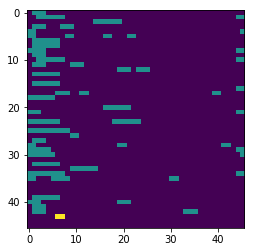

In [38]:
plt.imshow(environment.model_readable_representation())

# Making the Model

The model takes in 5 states of the environment and predicts the next state.
It's a VQ-VAE.

We first create the environment because the model must fit its environment, not the other way around.

We first define the hyperparameters.
We use a `Z_dim` of 36 because the final model will use a 6x6x1 Z-representation instead of a continuous real vector.
We set `h_dim` to 200 because it seems like a good number.

In [9]:
X_dim = (width + 1) * (height + 1)
h_dim = 200
Z_dim = 36
minibatch_size = 1
lr = 0.001
n_train_epochs = 3
batch_size = 100

We can now make the model itself, which is a simple encoder-decoder model.

We use Xavier initialization for the weights.
The encoder is a 1-hidden-layer feed forward neural network, and the decoder is the same.

In [10]:
def xavier_init(size):
    input_dim = size[0]
    xavier_stdev = 1 / np.sqrt(input_dim / 2)
    return Variable(torch.randn(*size) * xavier_stdev, requires_grad=True)


Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whh = xavier_init(size=[h_dim, h_dim])
bhh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(X):
    h = nn.relu(X @ Wxh + bxh)
    h = nn.relu(h @ Whh + bhh)
    z_mu = h @ Whz_mu + bhz_mu
    z_var = h @ Whz_var + bhz_var
    max_z_var = 87.
    # we have to keep the variance within a reasonable bound
    # because we take the exponent of it when we find the loss,
    # and it overflows past max_z_var
    z_var = torch.clamp(z_var, min=-max_z_var, max=max_z_var)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(minibatch_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps


Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def P(z):
    h = nn.relu(z @ Wzh + bzh)
    X = torch.sigmoid(h @ Whx + bhx)
    return X

We now generate a dataset of $X$ and $y$ values.
Each $X$ value is a flattened frame, and the ground truth $y$ value is the next frame.

In [ ]:
n_data_points = 100000
X = np.zeros((n_data_points, (height + 1) * (width + 1)), dtype=np.float32)
y = np.zeros((n_data_points, (height + 1) * (width + 1)), dtype=np.float32)

for i in range(n_data_points // max_time + 1):
    environment = Environment(height, width, agent_pos, goal_pos, agent_speed, goal_vel, max_time, level)
    try:
        for j in range(max_time):
            rep = environment.model_readable_representation().flatten()
            # we can go faster by using the current frame as the previous frame's next frame

            try:
                X[i*max_time+j] = rep
            except IndexError:
                break

            try:
                y[i*max_time+j-1] = rep
            except IndexError:
                pass

            environment.move()
    except:
        pass
    
X = torch.from_numpy(X)
y = torch.from_numpy(y)

Let's train the model now.

In [ ]:
params = [Wxh, Whh, bhh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)
losses = []
losses_in_epoch = []
losses_avg_per_epoch = []

for epoch in range(n_train_epochs):
    print('Beginning epoch {}'.format(epoch))
    shuffled_indices = torch.randperm(len(X))
    batches_indices = []
    batch_indices = []
    for index in shuffled_indices:
        batch_indices.append(index)
        if len(batch_indices) == batch_size:
            batches_indices.append(batch_indices)
            batch_indices = []
            
    losses_in_epoch = []
    for batch_indices in batches_indices:
        batch = Variable(X[batch_indices])
        y_true = Variable(y[batch_indices])
        
        # Forward
        z_mu, z_var = Q(batch)
        z = sample_z(z_mu, z_var)
        y_pred = P(z)

        # Loss
        recon_loss = nn.binary_cross_entropy(y_pred, y_true, size_average=False) / minibatch_size
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss
        
        losses.append(loss)
        losses_in_epoch.append(loss)
        
        # Backward
        loss.backward()

        # Update
        solver.step()
        
    losses_avg_per_epoch.append(sum(losses_in_epoch) / len(batch_indices))

In [ ]:
plt.plot(medfilt(losses))
plt.yscale('log')

We can compare the model's predicted next frame with the actual next frame.

In [ ]:
environment = Environment(height, width, agent_pos, goal_pos, agent_speed, goal_vel, max_time, level)

frame = environment.model_readable_representation()
prediction = P(sample_z(*Q(environment.model_readable_representation().flatten().reshape(1, X_dim).float()))) \
             .reshape(int(X_dim ** 0.5), int(X_dim ** 0.5)).detach().numpy()
environment.move()
actual = environment.model_readable_representation()

cmap = LinearSegmentedColormap.from_list('mycmap', ['purple', 'yellow', 'blue'])

plt.figure(figsize=(10, 10))
plt.suptitle('Model Predictions', fontsize='xx-large')
plt.subplot(231)
plt.title('Current frame')
plt.imshow(frame, cmap=cmap)
plt.subplot(232)
plt.title('Predicted frame')
plt.imshow(prediction, cmap=cmap)
plt.subplot(233)
plt.title('Actual next frame')
plt.imshow(actual, cmap=cmap)
plt.tight_layout()

In [ ]:
environment = Environment(height, width, agent_pos, goal_pos, agent_speed, goal_vel, max_time, level)
e1 = environment.model_readable_representation()
environment.move()
(e1 == environment.model_readable_representation()).all()